In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split


### Get all the data that we can from apple watch and form a csv that makes sense

In [2]:
file_path1 = 'data/HKQuantityTypeIdentifierSwimmingStrokeCount.csv'
file_path2 = 'data/HKQuantityTypeIdentifierDistanceSwimming.csv'
file_path3 = 'data/HKQuantityTypeIdentifierActiveEnergyBurned.csv'
file_path4 = 'data/HKQuantityTypeIdentifierDistanceCycling.csv'
file_path5 = 'data/HKQuantityTypeIdentifierDistanceWalkingRunning.csv'
file_path6 = 'data/HKQuantityTypeIdentifierHeartRate.csv'
file_path7 = 'data/HKQuantityTypeIdentifierStepCount.csv'

In [3]:
file_path = 'integrated_workout_data.csv'
df = pd.read_csv(file_path, delimiter=',', skiprows=0, on_bad_lines='skip',low_memory=False)
df = df[['Timestamp', 'Activity', 'Speed']]
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('10s')

df3 = pd.read_csv(file_path3, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df.columns = [col.strip() for col in df.columns]
df3.columns = [col.strip() for col in df3.columns]
df3['startdate'] = pd.to_datetime(df3['startdate'])
df3['enddate'] = pd.to_datetime(df3['enddate'])
df3['Timestamp'] = df3['startdate']
df3['Timestamp'] = pd.to_datetime(df3['Timestamp']).dt.round('10s')
df3 = df3[['Timestamp', 'value']]

merged_df_test = pd.merge(df, df3, on=['Timestamp'],how='left', suffixes=('', '_energy'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns
resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()
# resampled_df_test['value_energy'] = resampled_df_test['value']


In [4]:
df6 = pd.read_csv(file_path6, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df6.columns = [col.strip() for col in df6.columns]
df6['startdate'] = pd.to_datetime(df6['startdate'])
df6['enddate'] = pd.to_datetime(df6['enddate'])
df6['Timestamp'] = df6['startdate']
df6['Timestamp'] = pd.to_datetime(df6['Timestamp']).dt.round('10s')
df6 = df6[['Timestamp', 'value']]
merged_df_test = pd.merge(resampled_df_test, df6, on=['Timestamp'],how='left', suffixes=('', '_heartbeat'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [5]:
df4 = pd.read_csv(file_path4, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df4.columns = [col.strip() for col in df4.columns]
df4['startdate'] = pd.to_datetime(df4['startdate'])
df4['enddate'] = pd.to_datetime(df4['enddate'])
df4['Timestamp'] = df4['startdate']
df4['Timestamp'] = pd.to_datetime(df4['Timestamp']).dt.round('10s')
df4 = df4[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df4, on=['Timestamp'],how='left', suffixes=('', '_distancecycling'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns


resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [6]:
df5 = pd.read_csv(file_path5, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df5.columns = [col.strip() for col in df5.columns]
df5['startdate'] = pd.to_datetime(df5['startdate'])
df5['enddate'] = pd.to_datetime(df5['enddate'])
df5['Timestamp'] = df5['startdate']
df5['Timestamp'] = pd.to_datetime(df5['Timestamp']).dt.round('10s')
df5 = df5[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df5, on=['Timestamp'],how='left', suffixes=('', '_distancewalkrun'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns

resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()

In [7]:
df7 = pd.read_csv(file_path7, delimiter=';', skiprows=1, on_bad_lines='skip',low_memory=False)
df7.columns = [col.strip() for col in df7.columns]
df7['startdate'] = pd.to_datetime(df7['startdate'])
df7['enddate'] = pd.to_datetime(df7['enddate'])
df7['Timestamp'] = df7['startdate']
df7['Timestamp'] = pd.to_datetime(df7['Timestamp']).dt.round('10s')
df7 = df7[['Timestamp', 'value']]

merged_df_test = pd.merge(resampled_df_test, df7, on=['Timestamp'],how='left', suffixes=('', '_steps'))

numeric_columns = merged_df_test.select_dtypes(include='number').columns


resampled_df_test = merged_df_test.groupby('Timestamp')[numeric_columns].mean().reset_index()



In [8]:
output_path_test = 'merged_file_test.csv'
resampled_df_test.to_csv(output_path_test, index=False)

ditch the whole data. Only keep the last 3 months that have a lot of data.

In [9]:
output_path_df_test = 'df_file_test.csv'
df_test = resampled_df_test.tail(4600)
df_test.to_csv(output_path_df_test, index=False)

Show the values that are not filled. We have 278 NAN values for values -> energy. Fix it if we have time. Should be named values_energy instead of values

In [10]:
nan_values_per_column = df_test.isna().sum()

print(nan_values_per_column)

Timestamp                   0
Speed                       0
value                     278
value_heartbeat             3
value_distancecycling    3730
value_distancewalkrun    1336
value_steps              4427
dtype: int64


In [11]:

df_test['value'].fillna(0, inplace=True)

nan_values_per_column = df_test.isna().sum()

print(nan_values_per_column)

Timestamp                   0
Speed                       0
value                       0
value_heartbeat             3
value_distancecycling    3730
value_distancewalkrun    1336
value_steps              4427
dtype: int64


/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_24560/689802479.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['value'].fillna(0, inplace=True)
/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_24560/689802479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['value'].fillna(0, inplace=True)


Train a NN that uses the data from Speed in order to predict the values for the energy missing. The 278 values mentioned above

In [12]:



df = df_test

train_df = df[df['value'] != 0]
test_df = df[df['value'] == 0]


X_train = train_df['Speed'].values.reshape(-1, 1)
y_train = train_df['value'].values.reshape(-1, 1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 1
model = SimpleNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(model, train_loader, criterion, optimizer, epochs=25)

X_test = test_df['Speed'].values.reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predicted_values = model(X_test_tensor).numpy()

df.loc[df['value'] == 0, 'value'] = predicted_values.flatten()
output_file_path = 'df_value_predicted.csv'
df.to_csv(output_file_path, index=False)

Epoch [1/25], Loss: 0.0080
Epoch [2/25], Loss: 0.0014
Epoch [3/25], Loss: 0.0007
Epoch [4/25], Loss: 0.0024
Epoch [5/25], Loss: 0.0004
Epoch [6/25], Loss: 0.0056
Epoch [7/25], Loss: 0.0057
Epoch [8/25], Loss: 0.0119
Epoch [9/25], Loss: 0.0034
Epoch [10/25], Loss: 0.0017
Epoch [11/25], Loss: 0.0049
Epoch [12/25], Loss: 0.0032
Epoch [13/25], Loss: 0.0007
Epoch [14/25], Loss: 0.0056
Epoch [15/25], Loss: 0.0005
Epoch [16/25], Loss: 0.0007
Epoch [17/25], Loss: 0.0014
Epoch [18/25], Loss: 0.0036
Epoch [19/25], Loss: 0.0150
Epoch [20/25], Loss: 0.0023
Epoch [21/25], Loss: 0.0004
Epoch [22/25], Loss: 0.0014
Epoch [23/25], Loss: 0.0000
Epoch [24/25], Loss: 0.0054
Epoch [25/25], Loss: 0.0003


In [13]:
file_path = 'df_value_predicted.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
df.sort_values('Timestamp', inplace=True)

def fill_nan_heartbeat(df):
    for i in range(len(df)):
        if pd.isna(df.loc[i, 'value_heartbeat']):
            start_idx = max(i - 2, 0)
            end_idx = min(i + 3, len(df))
            surrounding_values = df.loc[start_idx:end_idx, 'value_heartbeat']
            mean_value = surrounding_values.mean()
            df.loc[i, 'value_heartbeat'] = mean_value
    return df

df = fill_nan_heartbeat(df)
output_file_path = 'df_heartbeat_filled.csv'
df.to_csv(output_file_path, index=False)
print(df.head())


                  Timestamp     Speed     value  value_heartbeat  \
0 2024-02-05 14:54:30+00:00  1.640148  0.322667       123.500000   
1 2024-02-05 14:54:40+00:00  1.712500  0.339000       123.666667   
2 2024-02-05 14:54:50+00:00  1.634478  0.396750       124.000000   
3 2024-02-05 14:55:00+00:00  1.324659  0.377000       124.666667   
4 2024-02-05 14:55:10+00:00  1.459364  0.310500       124.000000   

   value_distancecycling  value_distancewalkrun  value_steps  
0                    NaN               0.004820        884.0  
1                    NaN               0.004316          NaN  
2                    NaN               0.004186          NaN  
3                    NaN               0.002988          NaN  
4                    NaN               0.004114          NaN  


Show that the values are now filled with the predictions of the neural network

In [14]:

nan_values_per_column = df.isna().sum()

print(nan_values_per_column)

Timestamp                   0
Speed                       0
value                       0
value_heartbeat             0
value_distancecycling    3730
value_distancewalkrun    1336
value_steps              4427
dtype: int64


Plot all the data after we have included the missing values. I belueve this should not be included but rather the other plot of the last 100 cells which is more informative

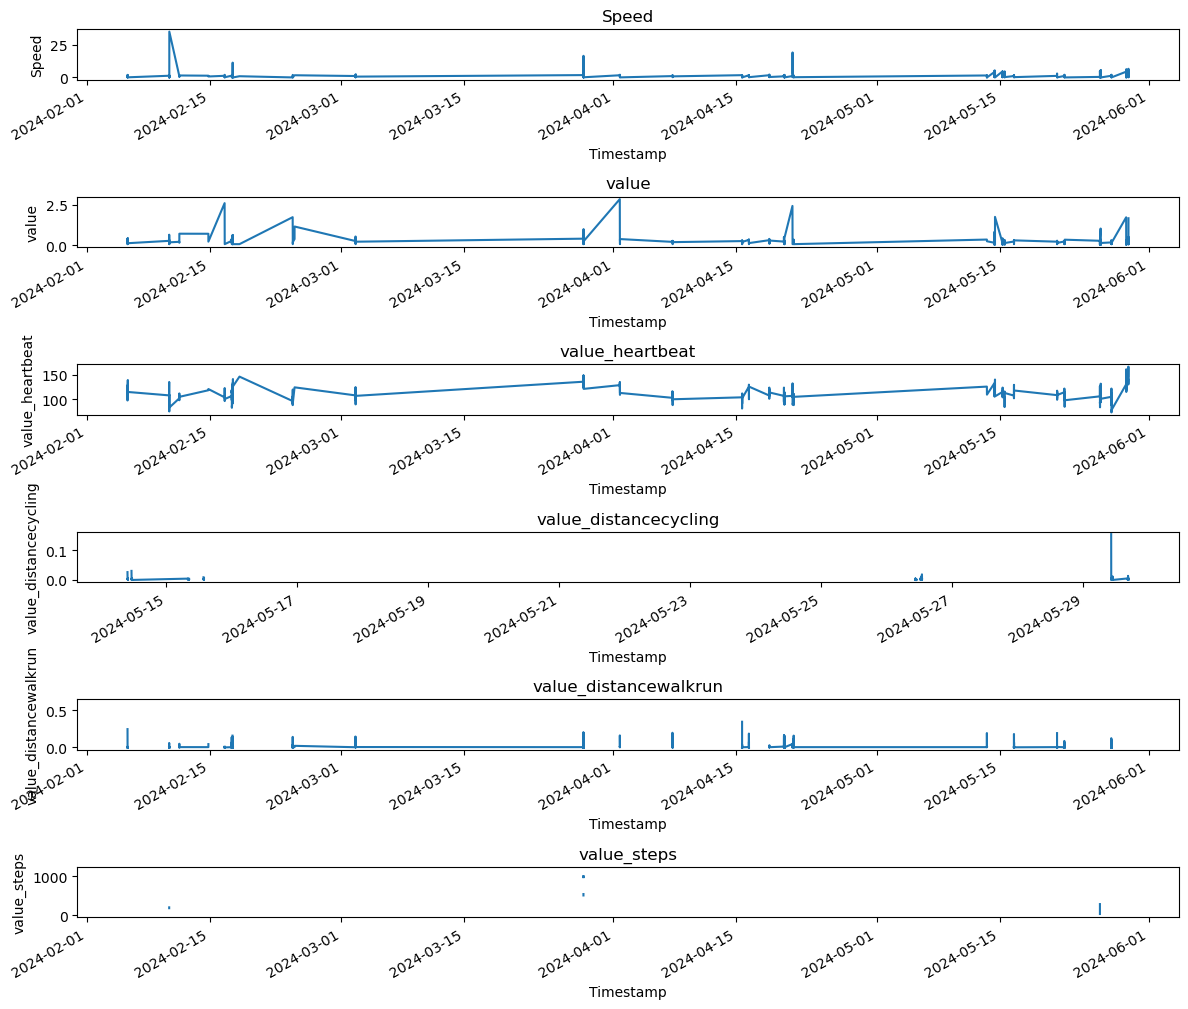

In [15]:
import matplotlib.pyplot as plt

file_path = 'df_heartbeat_filled.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
# Convert the Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as the index
df.set_index('Timestamp', inplace=True)

# Define the number of subplots based on the number of columns (excluding the index)
num_plots = df.shape[1]

# Create subplots
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 1.7 * num_plots))

# Plot each column in a separate subplot
for i, column in enumerate(df.columns):
    df[column].plot(ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


This should be part of the overleaf. Georgios told me we should definetely have something like this in our latex. Makes more sense and looks good

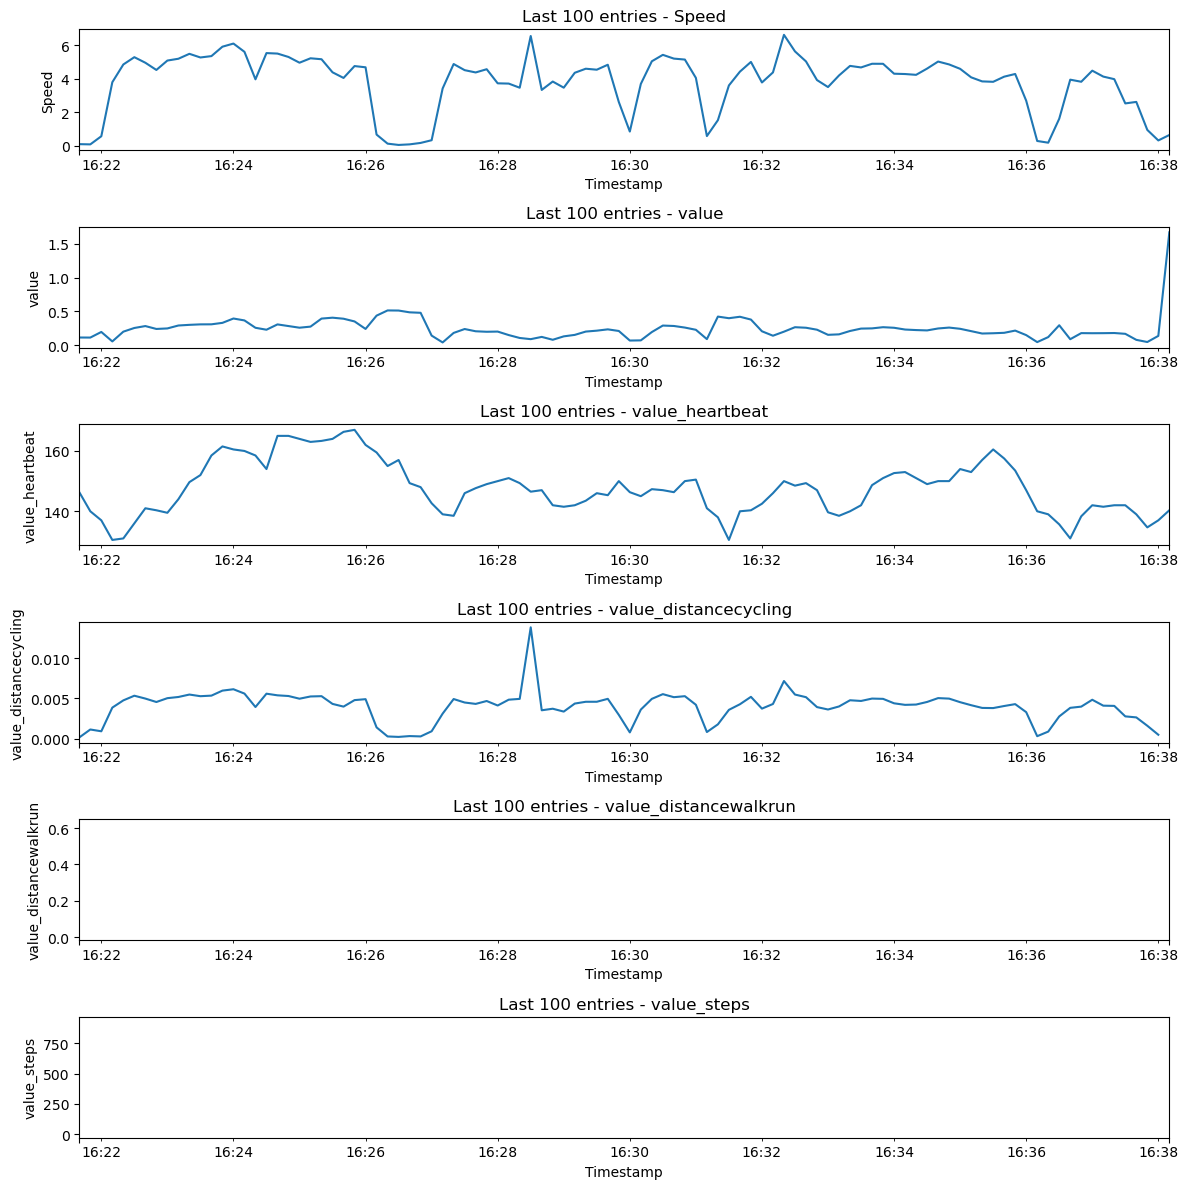

In [16]:
# Plot the last 100 entries of the dataframe
df_last_100 = df.tail(100)

# Create subplots for the last 100 entries
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2 * num_plots))

# Plot each column in a separate subplot for the last 100 entries
for i, column in enumerate(df_last_100.columns):
    df_last_100[column].plot(ax=axes[i])
    axes[i].set_title(f'Last 100 entries - {column}')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


PEarson and SPearman corellation matrices to check which of the columns are very close to each other.

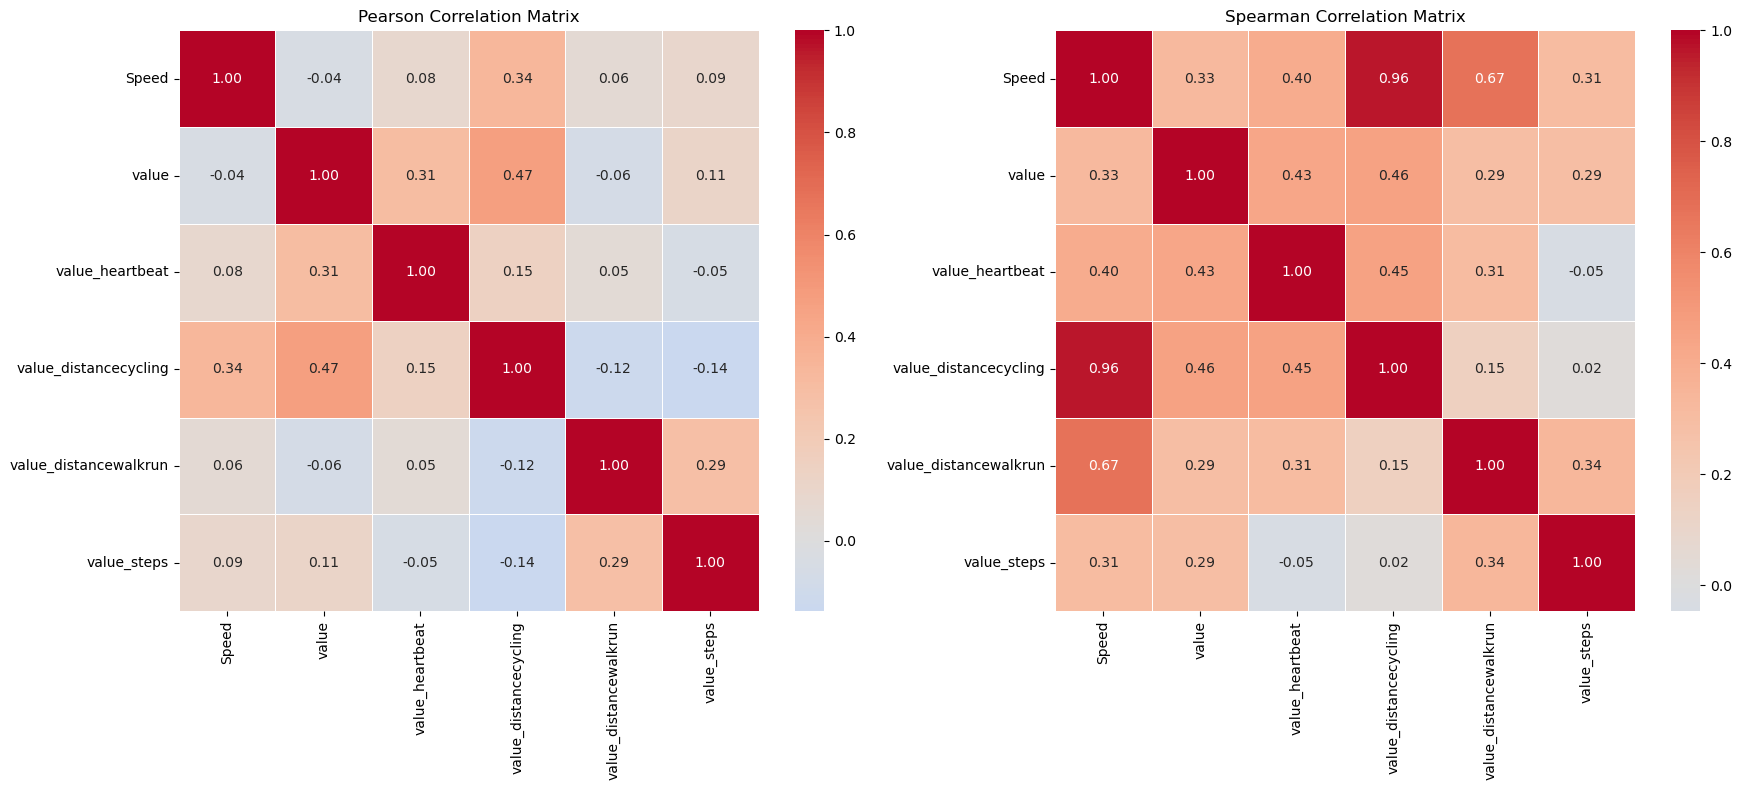

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'df_heartbeat_filled.csv'
df = pd.read_csv(file_path)

# Exclude non-numeric columns for correlation calculation
df_numeric = df.select_dtypes(include='number')

# Calculate correlation matrices
correlation_matrix = df_numeric.corr()
spearman_corr = df_numeric.corr(method='spearman')

# Plotting Pearson and Spearman correlation matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Pearson Correlation Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')

# Spearman Correlation Heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')

plt.tight_layout()
plt.show()


In [18]:
df_dropped = df.iloc[:, :-3]
df_dropped.head()
output_file_path = 'df_only_filled_values.csv'
df_dropped.to_csv(output_file_path, index=False)

### Kalman filter. His implementation on github was not working because of as_matrix, doesnt exist in numpy anymore and to_numpy made issues. Also shows the values that were removed. Huge values that didnt make so much sense.

In [19]:

# Define Kalman filter function
def kalman_filter(data, process_variance, estimated_measurement_variance):
    n = len(data)
    xhat = np.zeros(n)      # a posteri estimate of x
    P = np.zeros(n)         # a posteri error estimate
    xhatminus = np.zeros(n) # a priori estimate of x
    Pminus = np.zeros(n)    # a priori error estimate
    K = np.zeros(n)         # gain or blending factor

    # intial guesses
    xhat[0] = data[0]
    P[0] = 1.0

    for k in range(1, n):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + process_variance

        # measurement update
        K[k] = Pminus[k] / (Pminus[k] + estimated_measurement_variance)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# Process variance and measurement variance
process_variance = 1e-5
estimated_measurement_variance = 1e-1


# Apply Kalman filter to each column
filtered_df = df_dropped.copy()
columns_to_filter = ['Speed', 'value', 'value_heartbeat']

for column in columns_to_filter:
    filtered_values = kalman_filter(df[column].values, process_variance, estimated_measurement_variance)
    filtered_df[column] = filtered_values

# Identify removed values
removed_values = {}

for column in columns_to_filter:
    original_values = df[column].values
    filtered_values = filtered_df[column].values
    removed_values[column] = original_values[original_values != filtered_values]

# Create a DataFrame with the removed values
removed_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in removed_values.items()]))

# Display the DataFrame
print(removed_values_df.head())

# Optionally save the removed values DataFrame
removed_values_df.to_csv('kalman_filtered_df_fitted.csv', index=False)


      Speed    value  value_heartbeat
0  1.712500  0.33900       123.666667
1  1.634478  0.39675       124.000000
2  1.324659  0.37700       124.666667
3  1.459364  0.31050       124.000000
4  1.682841  0.35100       119.333333


Show the before and after appllying the kalman filter

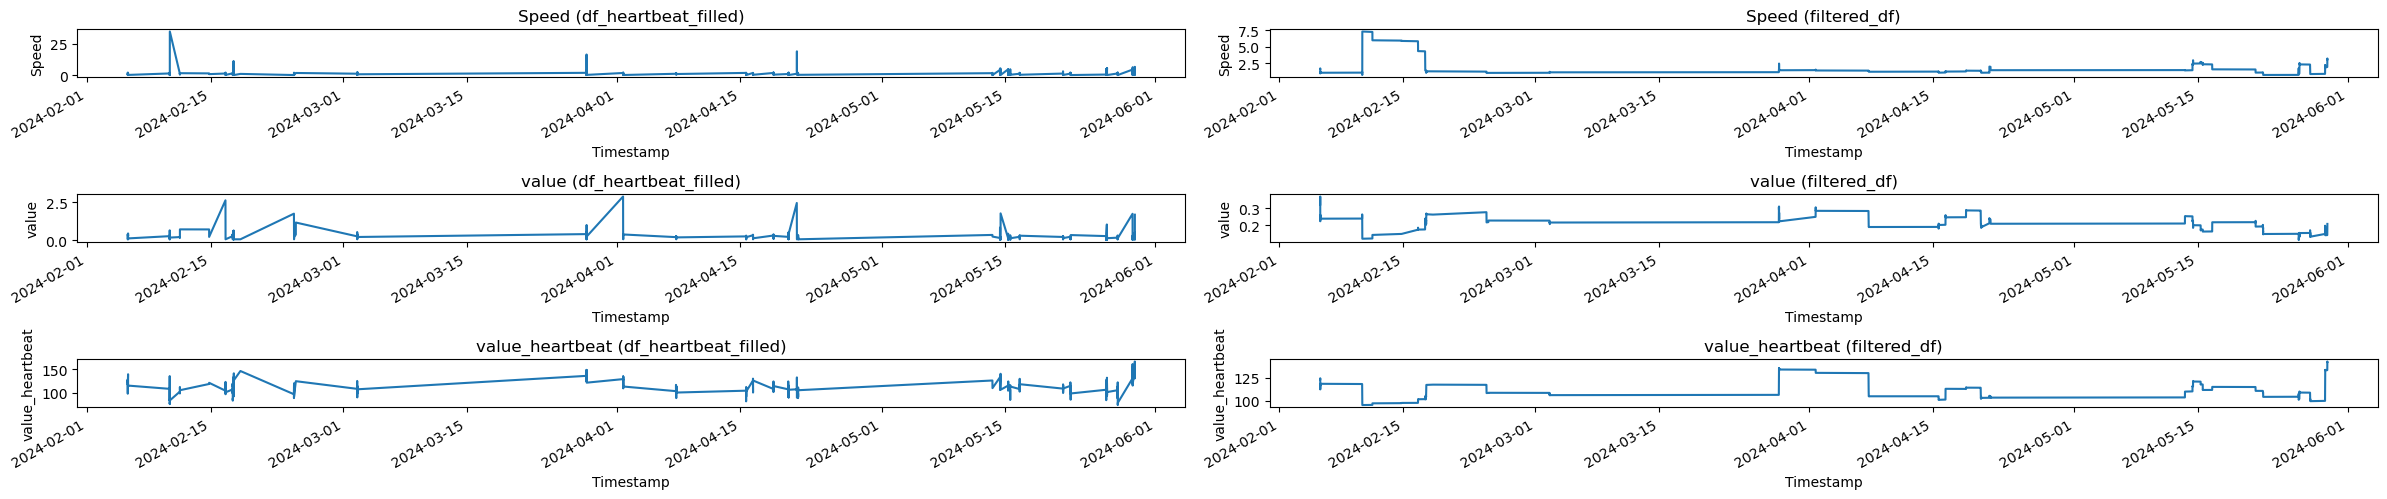

In [20]:


# Load and process the first dataframe
file_path1 = 'df_heartbeat_filled.csv'
df1 = pd.read_csv(file_path1, parse_dates=['Timestamp'])
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df1.set_index('Timestamp', inplace=True)

# Load and process the second dataframe
file_path2 = 'filtered_df.csv'
df2 = pd.read_csv(file_path2, parse_dates=['Timestamp'])
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])
df2.set_index('Timestamp', inplace=True)

# Filter df1 to keep only the columns present in df2
df1_filtered = df1[df2.columns]

# Define the number of subplots based on the number of columns in df2
num_plots = df2.shape[1]

# Create subplots with 2 columns
fig, axes = plt.subplots(num_plots, 2, figsize=(24, 1.7 * num_plots))

# Plot each column from the filtered first dataframe in the left column of subplots
for i, column in enumerate(df2.columns):
    df1_filtered[column].plot(ax=axes[i, 0])
    axes[i, 0].set_title(f'{column} (df_heartbeat_filled)')
    axes[i, 0].set_xlabel('Timestamp')
    axes[i, 0].set_ylabel(column)

# Plot each column from the second dataframe in the right column of subplots
for i, column in enumerate(df2.columns):
    df2[column].plot(ax=axes[i, 1])
    axes[i, 1].set_title(f'{column} (filtered_df)')
    axes[i, 1].set_xlabel('Timestamp')
    axes[i, 1].set_ylabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Feaature selection. Implementing a sliding window of size 30 where it smooths out the data by takuing the mean per slide over the data. Averages things out and smooths the data

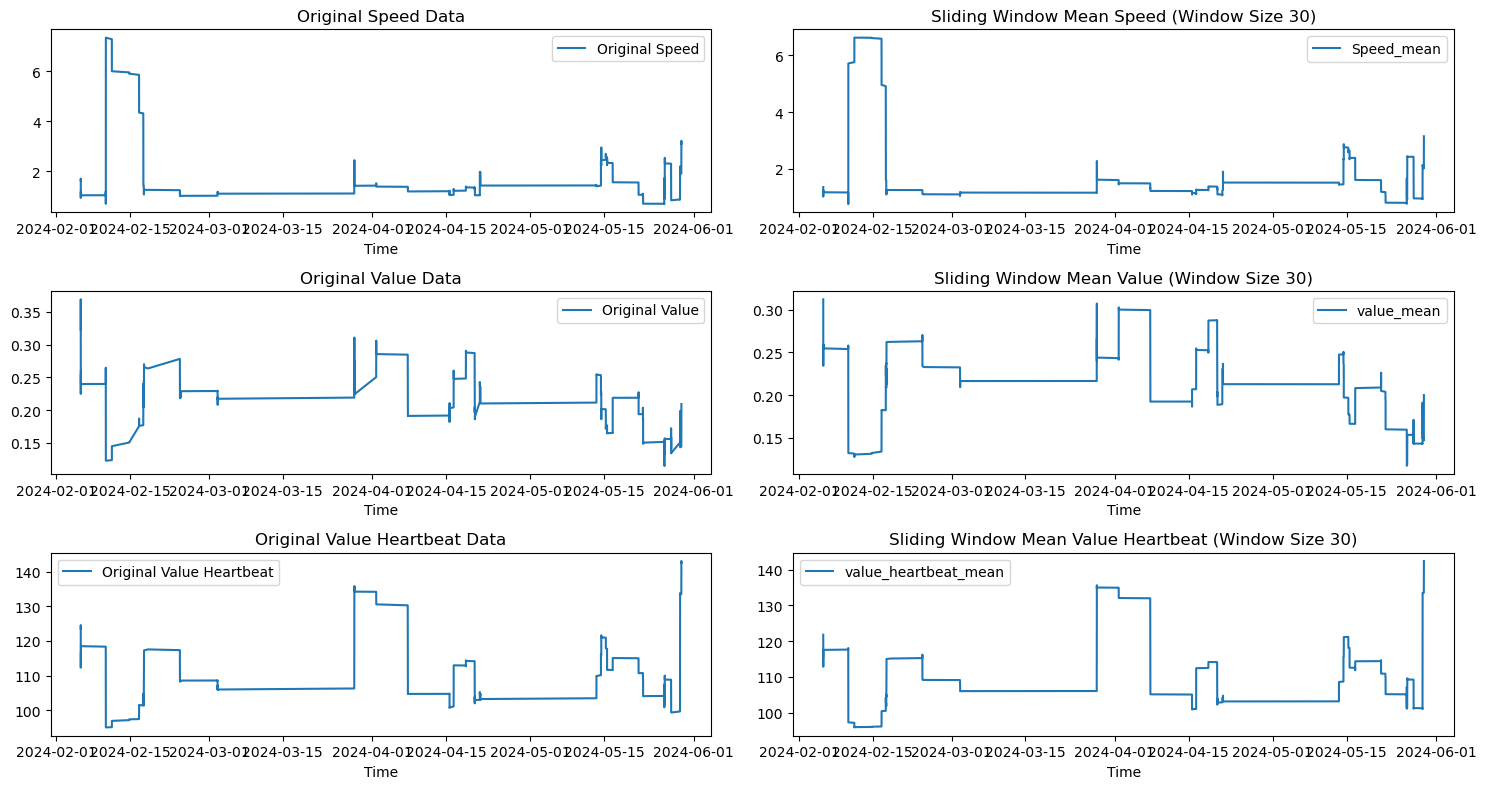

In [21]:
file_path = 'filtered_df.csv'
data = pd.read_csv(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
window_size = 30
rolling_features_30 = pd.DataFrame()
rolling_features_30['Speed_mean'] = data['Speed'].rolling(window=window_size).mean()
rolling_features_30['value_mean'] = data['value'].rolling(window=window_size).mean()
rolling_features_30['value_heartbeat_mean'] = data['value_heartbeat'].rolling(window=window_size).mean()
rolling_features_30 = rolling_features_30.iloc[window_size-1:].reset_index(drop=True)
timestamps_aligned = data['Timestamp'].iloc[window_size-1:].reset_index(drop=True)
rolling_features_30.to_csv('olling_features_30.csv', index=False)

# Plot the original data and the rolling window data side by side for comparison

plt.figure(figsize=(15, 8))

# Plot original and rolling window mean Speed data
plt.subplot(3, 2, 1)
plt.plot(data['Timestamp'], data['Speed'], label='Original Speed')
plt.title('Original Speed Data')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(timestamps_aligned, rolling_features_30['Speed_mean'], label='Speed_mean')
plt.title('Sliding Window Mean Speed (Window Size 30)')
plt.xlabel('Time')
plt.legend()

# Plot original and rolling window mean value data
plt.subplot(3, 2, 3)
plt.plot(data['Timestamp'], data['value'], label='Original Value')
plt.title('Original Value Data')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(timestamps_aligned, rolling_features_30['value_mean'], label='value_mean')
plt.title('Sliding Window Mean Value (Window Size 30)')
plt.xlabel('Time')
plt.legend()

# Plot original and rolling window mean value_heartbeat data
plt.subplot(3, 2, 5)
plt.plot(data['Timestamp'], data['value_heartbeat'], label='Original Value Heartbeat')
plt.title('Original Value Heartbeat Data')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(timestamps_aligned, rolling_features_30['value_heartbeat_mean'], label='value_heartbeat_mean')
plt.title('Sliding Window Mean Value Heartbeat (Window Size 30)')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

# Display the path of the saved file for the user



Also running the smoothing window for the last 100 measurements of our data. Here the averaging out - smoothing can be seen in more detail

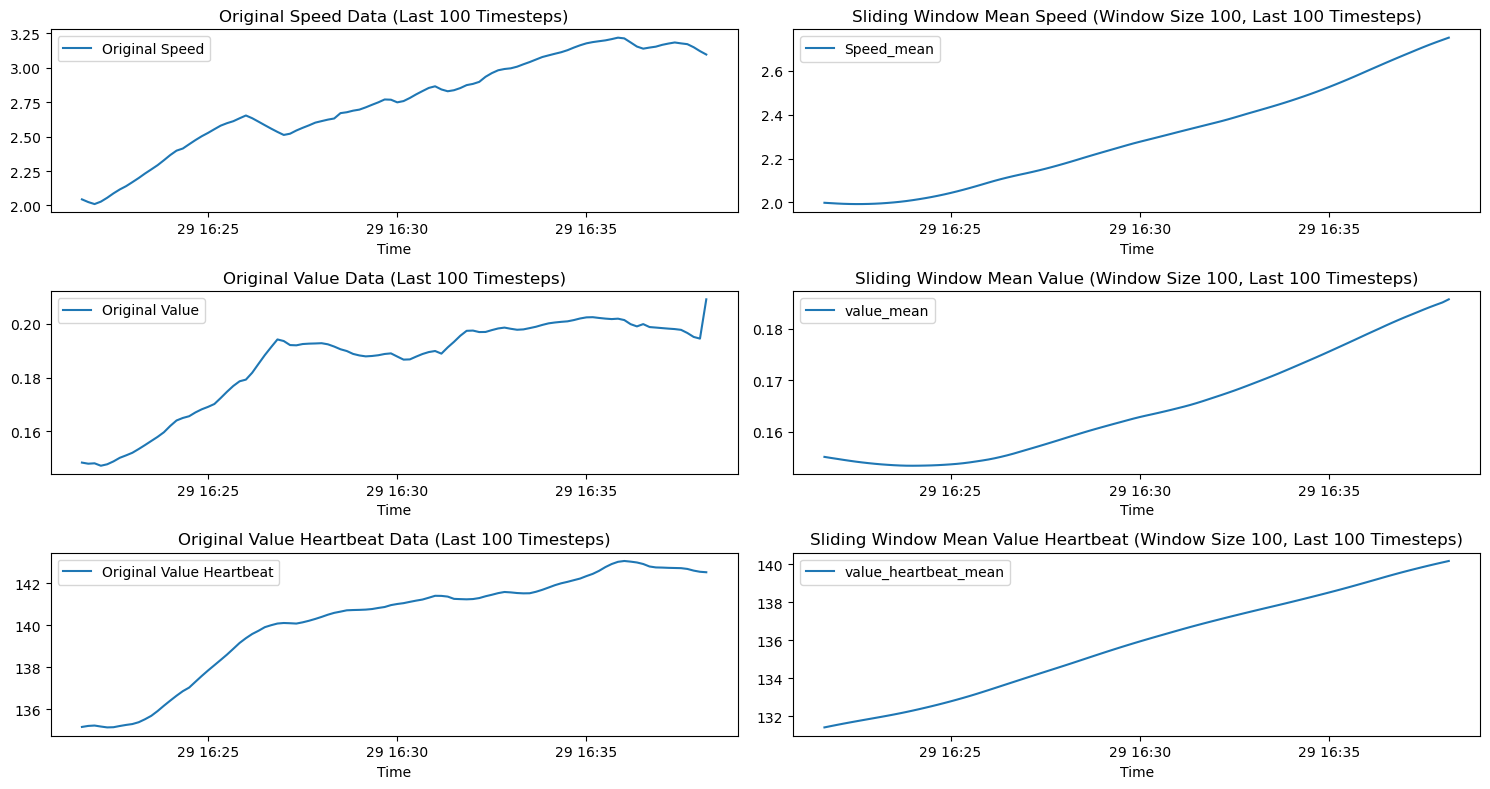

In [22]:


file_path = 'filtered_df.csv'
data = pd.read_csv(file_path)


data['Timestamp'] = pd.to_datetime(data['Timestamp'])


window_size = 100


rolling_features_100 = pd.DataFrame()


rolling_features_100['Speed_mean'] = data['Speed'].rolling(window=window_size).mean()
rolling_features_100['value_mean'] = data['value'].rolling(window=window_size).mean()
rolling_features_100['value_heartbeat_mean'] = data['value_heartbeat'].rolling(window=window_size).mean()


rolling_features_100 = rolling_features_100.iloc[window_size-1:].reset_index(drop=True)
timestamps_aligned_100 = data['Timestamp'].iloc[window_size-1:].reset_index(drop=True)





plt.figure(figsize=(15, 8))


plt.subplot(3, 2, 1)
plt.plot(data['Timestamp'].iloc[-100:], data['Speed'].iloc[-100:], label='Original Speed')
plt.title('Original Speed Data (Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(data['Timestamp'].iloc[-100:], rolling_features_100['Speed_mean'].iloc[-100:], label='Speed_mean')
plt.title('Sliding Window Mean Speed (Window Size 100, Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()


plt.subplot(3, 2, 3)
plt.plot(data['Timestamp'].iloc[-100:], data['value'].iloc[-100:], label='Original Value')
plt.title('Original Value Data (Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(data['Timestamp'].iloc[-100:], rolling_features_100['value_mean'].iloc[-100:], label='value_mean')
plt.title('Sliding Window Mean Value (Window Size 100, Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()

# Plot original and rolling window mean value_heartbeat data for the last 100 timesteps
plt.subplot(3, 2, 5)
plt.plot(data['Timestamp'].iloc[-100:], data['value_heartbeat'].iloc[-100:], label='Original Value Heartbeat')
plt.title('Original Value Heartbeat Data (Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(data['Timestamp'].iloc[-100:], rolling_features_100['value_heartbeat_mean'].iloc[-100:], label='value_heartbeat_mean')
plt.title('Sliding Window Mean Value Heartbeat (Window Size 100, Last 100 Timesteps)')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:


# # Load the dataset
# file_path = 'kalman_filtered_df_fitted.csv'
# data = pd.read_csv(file_path)

# # Feature Engineering: Adding polynomial and interaction features
# data['Speed_2'] = data['Speed'] ** 2
# data['Heartbeat_2'] = data['value_heartbeat'] ** 2
# data['Speed_Heartbeat'] = data['Speed'] * data['value_heartbeat']

# # Separate features and target variable with new features
# X = data[['Speed', 'value_heartbeat', 'Speed_2', 'Heartbeat_2', 'Speed_Heartbeat']].values
# y = data['value'].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Feature scaling
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X_train_scaled = scaler_X.fit_transform(X_train)
# X_test_scaled = scaler_X.transform(X_test)
# y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# # Linear Regression model
# linear_regressor = LinearRegression()
# linear_regressor.fit(X_train, y_train)
# y_pred_lr = linear_regressor.predict(X_test)

# mse_lr = mean_squared_error(y_test, y_pred_lr)
# r2_lr = r2_score(y_test, y_pred_lr)

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# input_size = X_train_scaled.shape[1]
# hidden_size = 50
# num_layers = 2
# output_size = 1

# lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# # Train the LSTM model
# num_epochs = 100
# X_train_tensor = torch.tensor(X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1])), dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
# for epoch in range(num_epochs):
#     lstm_model.train()
#     outputs = lstm_model(X_train_tensor)
#     optimizer.zero_grad()
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluate the LSTM model
# lstm_model.eval()
# X_test_tensor = torch.tensor(X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1])), dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
# with torch.no_grad():
#     y_pred_tensor = lstm_model(X_test_tensor)
#     y_pred_lstm = scaler_y.inverse_transform(y_pred_tensor.cpu().numpy())
#     y_test_lstm = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

#     mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
#     r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

# # Random Forest model
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred_rf = rf_model.predict(X_test)

# mse_rf = mean_squared_error(y_test, y_pred_rf)
# r2_rf = r2_score(y_test, y_pred_rf)

# # Gradient Boosting model
# gb_model = GradientBoostingRegressor(random_state=42)
# gb_model.fit(X_train, y_train)
# y_pred_gb = gb_model.predict(X_test)

# mse_gb = mean_squared_error(y_test, y_pred_gb)
# r2_gb = r2_score(y_test, y_pred_gb)

# # Define the Transformer Decoder-Only model
# class TransformerModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads):
#         super(TransformerModel, self).__init__()
#         self.embedding = nn.Linear(input_size, hidden_size)
#         self.pos_encoder = nn.Parameter(torch.zeros(1, input_size, hidden_size))
#         self.decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
#         self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         x = self.embedding(x) + self.pos_encoder
#         x = self.transformer_decoder(x, x)
#         x = self.fc(x[:, -1, :])
#         return x

# input_size = X_train_tensor.shape[2]
# hidden_size = 50
# num_layers = 2
# output_size = 1
# num_heads = 2

# transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# # Train the Transformer model
# for epoch in range(num_epochs):
#     transformer_model.train()
#     outputs = transformer_model(X_train_tensor)
#     optimizer.zero_grad()
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluate the Transformer model
# transformer_model.eval()
# with torch.no_grad():
#     y_pred_tensor = transformer_model(X_test_tensor)
#     y_pred_transformer = scaler_y.inverse_transform(y_pred_tensor.cpu().numpy())
#     y_test_transformer = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

#     mse_transformer = mean_squared_error(y_test_transformer, y_pred_transformer)
#     r2_transformer = r2_score(y_test_transformer, y_pred_transformer)

# # Simulate prediction for the next day using the last values in the dataset
# last_values_scaled = scaler_X.transform(data.iloc[-1][['Speed', 'value_heartbeat', 'Speed_2', 'Heartbeat_2', 'Speed_Heartbeat']].values.reshape(1, -1))
# last_values_tensor = torch.tensor(last_values_scaled.reshape((1, 1, 5)), dtype=torch.float32)

# # Predictions for the next day for all models
# predicted_value_lr = linear_regressor.predict(last_values_scaled)[0]
# predicted_value_rf = rf_model.predict(last_values_scaled)[0]
# predicted_value_gb = gb_model.predict(last_values_scaled)[0]

# with torch.no_grad():
#     predicted_value_tensor_lstm = lstm_model(last_values_tensor)
#     predicted_value_lstm = scaler_y.inverse_transform(predicted_value_tensor_lstm.cpu().numpy())[0, 0]
    
#     predicted_value_tensor_transformer = transformer_model(last_values_tensor)
#     predicted_value_transformer = scaler_y.inverse_transform(predicted_value_tensor_transformer.cpu().numpy())[0, 0]

# # Performance comparison
# performance_comparison = {
#     'Model': ['Linear Regression', 'LSTM', 'Random Forest', 'Gradient Boosting', 'Transformer'],
#     'MSE': [mse_lr, mse_lstm, mse_rf, mse_gb, mse_transformer],
#     'R²': [r2_lr, r2_lstm, r2_rf, r2_gb, r2_transformer],
#     'Predicted value for the next day': [predicted_value_lr, predicted_value_lstm, predicted_value_rf, predicted_value_gb, predicted_value_transformer]
# }

# performance_comparison_df = pd.DataFrame(performance_comparison)
# print(performance_comparison_df)


### Moving into the prediction. 5 models were made and tested for the prediction. We need to write details about every model used. I have also included Rsquared to check the fit (Fit is not very good)

In [24]:
# Load the dataset
file_path = 'kalman_filtered_df_fitted.csv'
data = pd.read_csv(file_path)

# Feature Engineering: Adding polynomial and interaction features
data['Speed_2'] = data['Speed'] ** 2
data['Heartbeat_2'] = data['value_heartbeat'] ** 2
data['Speed_Heartbeat'] = data['Speed'] * data['value_heartbeat']

# Separate features and target variable with new features
X = data[['Speed', 'value_heartbeat', 'Speed_2', 'Heartbeat_2', 'Speed_Heartbeat']].values
y = data['value'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

## Linear regression    

In [25]:
# Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred_lr = linear_regressor.predict(X_test)
y_pred_lr = np.maximum(y_pred_lr, 0)  # Ensure predictions are >= 0

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)


## LSTM model

In [26]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_scaled.shape[1]
hidden_size = 50
num_layers = 2
output_size = 1

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
num_epochs = 100
X_train_tensor = torch.tensor(X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1])), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
for epoch in range(num_epochs):
    lstm_model.train()
    outputs = lstm_model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the LSTM model
lstm_model.eval()
X_test_tensor = torch.tensor(X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1])), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
with torch.no_grad():
    y_pred_tensor = lstm_model(X_test_tensor)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_tensor.cpu().numpy())
    y_test_lstm = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

    mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
    r2_lstm = r2_score(y_test_lstm, y_pred_lstm)


Epoch [10/100], Loss: 0.0060
Epoch [20/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0018
Epoch [50/100], Loss: 0.0017
Epoch [60/100], Loss: 0.0017
Epoch [70/100], Loss: 0.0017
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0017
Epoch [100/100], Loss: 0.0017


## Random forest model

In [27]:
# Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


## Gradient boosting

In [28]:
# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)


## Decoder only transformers 

In [29]:
# Define the Transformer Decoder-Only model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, input_size, hidden_size))
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x) + self.pos_encoder
        x = self.transformer_decoder(x, x)
        x = self.fc(x[:, -1, :])
        return x

input_size = X_train_tensor.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1
num_heads = 2

transformer_model = TransformerModel(input_size, hidden_size, num_layers, output_size, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Train the Transformer model
for epoch in range(num_epochs):
    transformer_model.train()
    outputs = transformer_model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the Transformer model
transformer_model.eval()
with torch.no_grad():
    y_pred_tensor = transformer_model(X_test_tensor)
    y_pred_transformer = scaler_y.inverse_transform(y_pred_tensor.cpu().numpy())
    y_test_transformer = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

    mse_transformer = mean_squared_error(y_test_transformer, y_pred_transformer)
    r2_transformer = r2_score(y_test_transformer, y_pred_transformer)


Epoch [10/100], Loss: 0.0537


KeyboardInterrupt: 

In [ ]:
# Simulate prediction for the next day using the last values in the dataset
last_values_scaled = scaler_X.transform(data.iloc[-1][['Speed', 'value_heartbeat', 'Speed_2', 'Heartbeat_2', 'Speed_Heartbeat']].values.reshape(1, -1))
last_values_tensor = torch.tensor(last_values_scaled.reshape((1, 1, 5)), dtype=torch.float32)

# Predictions for the next day for all models
predicted_value_lr = linear_regressor.predict(last_values_scaled)[0]
predicted_value_rf = rf_model.predict(last_values_scaled)[0]
predicted_value_gb = gb_model.predict(last_values_scaled)[0]

with torch.no_grad():
    predicted_value_tensor_lstm = lstm_model(last_values_tensor)
    predicted_value_lstm = scaler_y.inverse_transform(predicted_value_tensor_lstm.cpu().numpy())[0, 0]
    
    predicted_value_tensor_transformer = transformer_model(last_values_tensor)
    predicted_value_transformer = scaler_y.inverse_transform(predicted_value_tensor_transformer.cpu().numpy())[0, 0]

# Performance comparison
performance_comparison = {
    'Model': ['Linear Regression', 'LSTM', 'Random Forest', 'Gradient Boosting', 'Transformer'],
    'MSE': [mse_lr, mse_lstm, mse_rf, mse_gb, mse_transformer],
    'R²': [r2_lr, r2_lstm, r2_rf, r2_gb, r2_transformer],
    'Predicted value for the next day': [predicted_value_lr, predicted_value_lstm, predicted_value_rf, predicted_value_gb, predicted_value_transformer]
}

performance_comparison_df = pd.DataFrame(performance_comparison)
print(performance_comparison_df)


               Model       MSE        R²  Predicted value for the next day
0  Linear Regression  0.012964  0.137173                         -0.791106
1               LSTM  0.013408  0.107598                          0.282470
2      Random Forest  0.012398  0.174834                          0.125693
3  Gradient Boosting  0.012764  0.150455                          0.147852
4        Transformer  0.013995  0.068548                          0.233634


In [ ]:
# Calculate the accuracy of each model

# Assuming you have the true and predicted values for each model
models = ['Linear Regression', 'LSTM', 'Random Forest', 'Gradient Boosting', 'Transformer']
mse_values = [mse_lr, mse_lstm, mse_rf, mse_gb, mse_transformer]
r2_values = [r2_lr, r2_lstm, r2_rf, r2_gb, r2_transformer]
predicted_values = [predicted_value_lr, predicted_value_lstm, predicted_value_rf, predicted_value_gb, predicted_value_transformer]

# Finding the model with the best prediction (highest R² score)
best_model_index = np.argmax(r2_values)
best_model_name = models[best_model_index]
best_model_r2 = r2_values[best_model_index]

# Calculate accuracy as (1 - MSE/Variance of the target variable)
variance_y_test = np.var(y_test)
accuracy_lr = 1 - mse_lr / variance_y_test
accuracy_lstm = 1 - mse_lstm / variance_y_test
accuracy_rf = 1 - mse_rf / variance_y_test
accuracy_gb = 1 - mse_gb / variance_y_test
accuracy_transformer = 1 - mse_transformer / variance_y_test

accuracies = [accuracy_lr, accuracy_lstm, accuracy_rf, accuracy_gb, accuracy_transformer]

# Adding accuracies to the performance comparison DataFrame
performance_comparison['Accuracy'] = accuracies

# Print the performance comparison DataFrame with accuracies
print(performance_comparison_df)

# Print the model with the best prediction
print(f"The model with the best prediction is {best_model_name} with an R² score of {best_model_r2:.4f}")


               Model       MSE        R²  Predicted value for the next day
0  Linear Regression  0.012964  0.137173                         -0.791106
1               LSTM  0.013408  0.107598                          0.282470
2      Random Forest  0.012398  0.174834                          0.125693
3  Gradient Boosting  0.012764  0.150455                          0.147852
4        Transformer  0.013995  0.068548                          0.233634
The model with the best prediction is Random Forest with an R² score of 0.1748


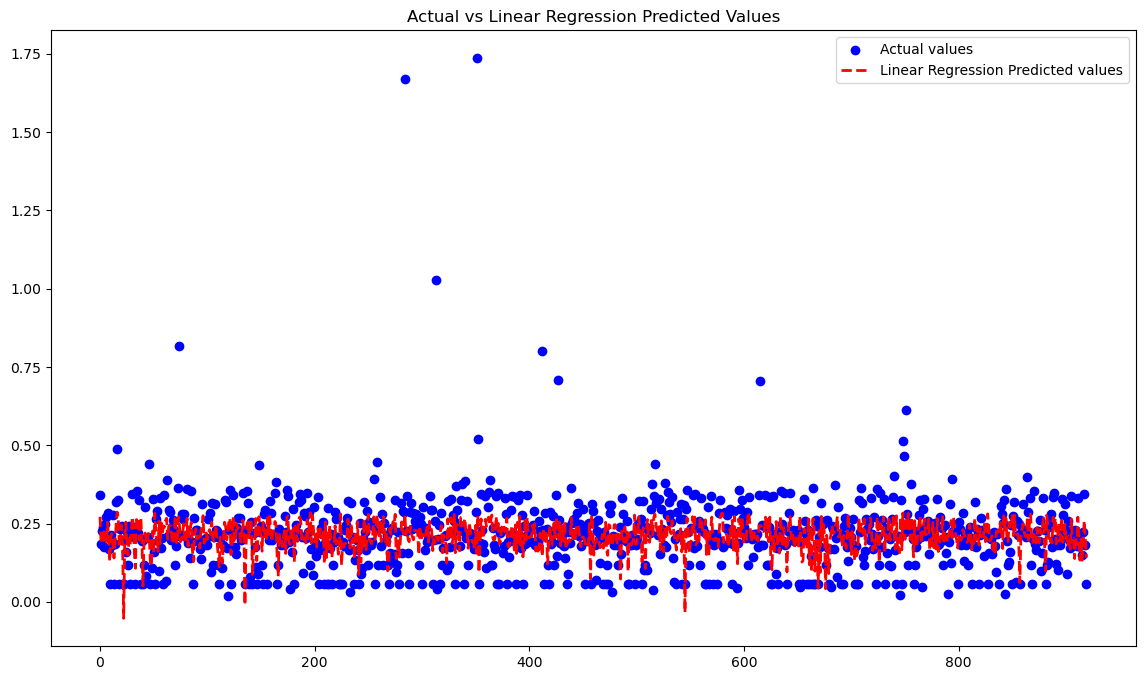

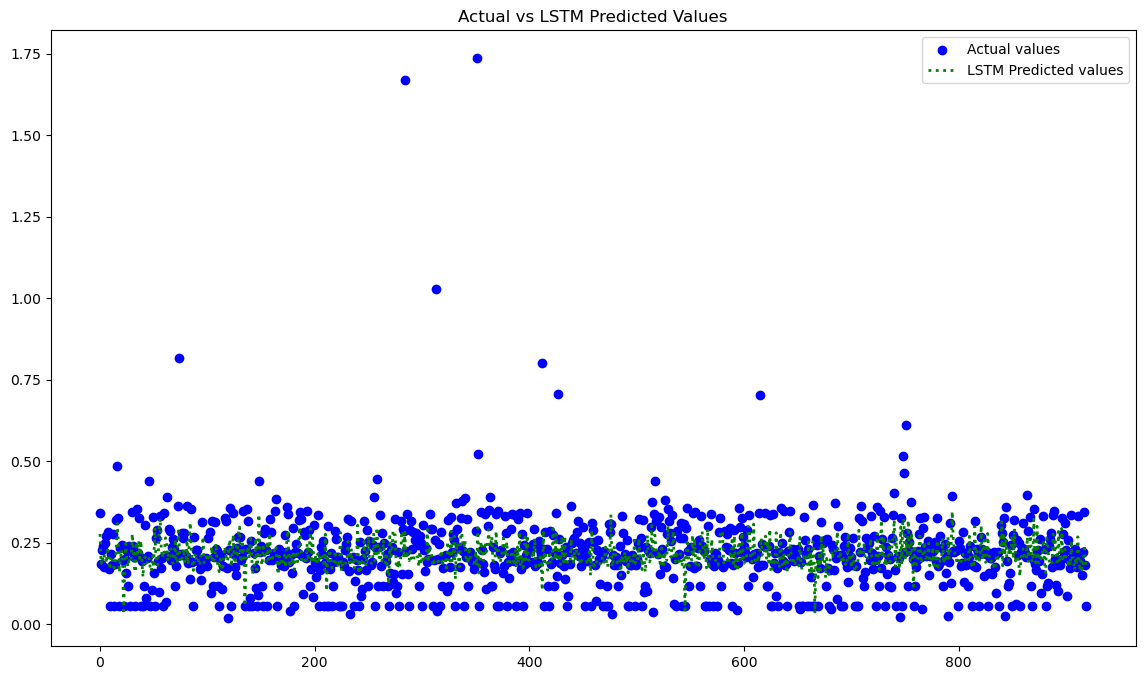

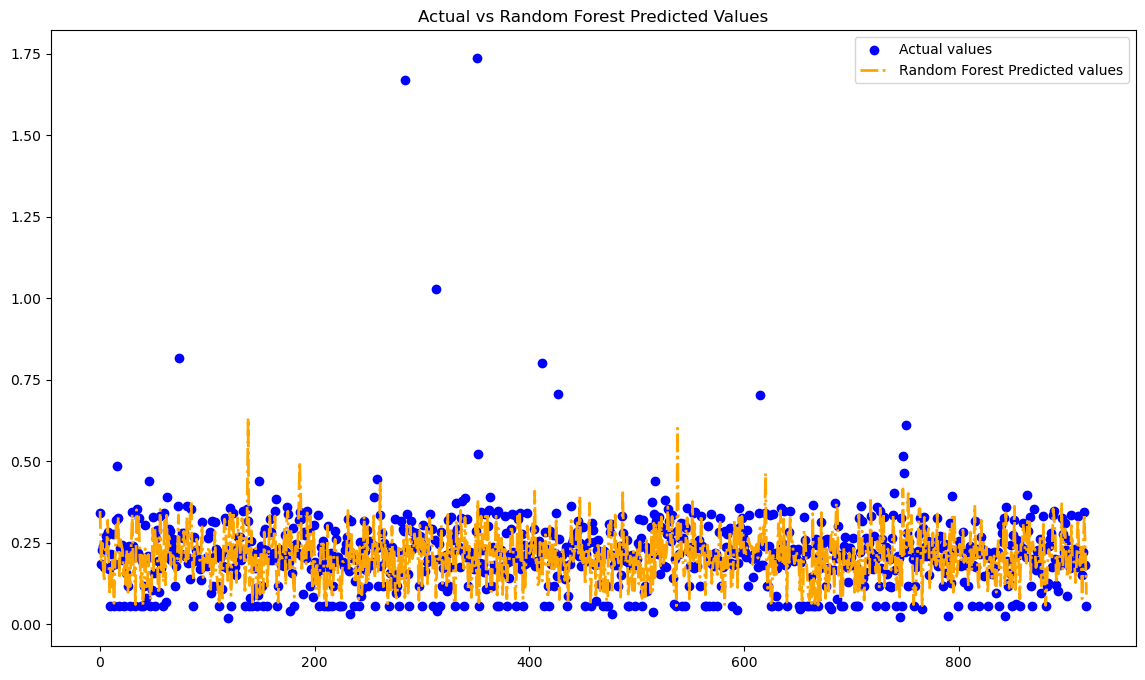

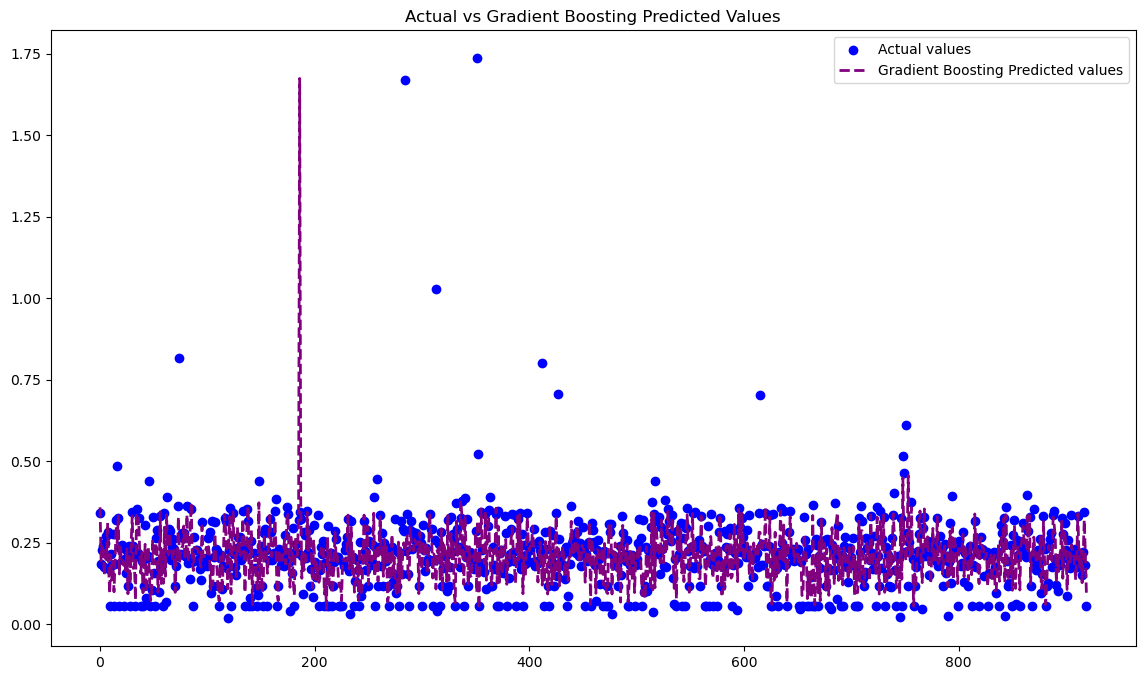

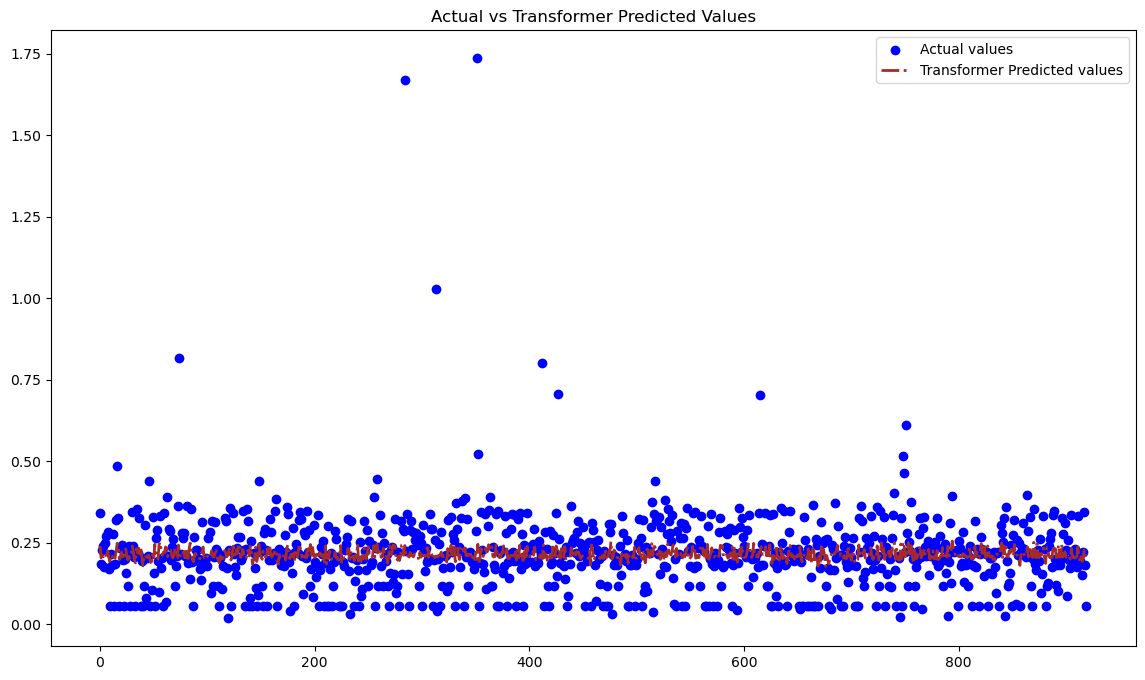

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and predictions (y_pred_lr, y_pred_lstm, y_pred_rf, y_pred_gb, y_pred_transformer) are already defined from your code

# Actual vs Linear Regression Predicted values
plt.figure(figsize=(14, 8))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred_lr)), y_pred_lr, color='red', linestyle='dashed', linewidth=2, label='Linear Regression Predicted values')
plt.title('Actual vs Linear Regression Predicted Values')
plt.legend()
plt.show()

# Actual vs LSTM Predicted values
plt.figure(figsize=(14, 8))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred_lstm)), y_pred_lstm, color='green', linestyle='dotted', linewidth=2, label='LSTM Predicted values')
plt.title('Actual vs LSTM Predicted Values')
plt.legend()
plt.show()

# Actual vs Random Forest Predicted values
plt.figure(figsize=(14, 8))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred_rf)), y_pred_rf, color='orange', linestyle='dashdot', linewidth=2, label='Random Forest Predicted values')
plt.title('Actual vs Random Forest Predicted Values')
plt.legend()
plt.show()

# Actual vs Gradient Boosting Predicted values
plt.figure(figsize=(14, 8))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred_gb)), y_pred_gb, color='purple', linestyle='dashed', linewidth=2, label='Gradient Boosting Predicted values')
plt.title('Actual vs Gradient Boosting Predicted Values')
plt.legend()
plt.show()

# Actual vs Transformer Predicted values
plt.figure(figsize=(14, 8))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred_transformer)), y_pred_transformer, color='brown', linestyle='dashdot', linewidth=2, label='Transformer Predicted values')
plt.title('Actual vs Transformer Predicted Values')
plt.legend()
plt.show()
